# Introduction

Once the sequenced reads are processed using SEQC, this automated notebook is run to visualize and obtain some basic information about the data.

This notebook loads the SEQC filtered output, normalized the count matrix, performs dimensionality reduction, visualizes the cells, clusters the cells and performs differential expression to identify enriched genes in each cluster. 

## Import packages

In [1]:
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata
from scipy import sparse
import phenograph

In [2]:
sample_name = "2_DT_2_CD45plus_dense"

input_directory = "./inputs/"
output_directory = "./outputs/"

# Load data 

In [3]:
adata = sc.read_h5ad(os.path.join(input_directory, f"{sample_name}.h5ad"))

In [4]:
# View the cell barcodes:
adata.obs.head()

""
120703424257380
120703455455644
120703455480742
120726897191836
120726912354163


In [5]:
# View the gene names:
adata.var.head()

""
GNAI3
CDC45
APOH
NARF
CAV2


# QC

In [6]:
adata

AnnData object with n_obs × n_vars = 2610 × 15199

In [7]:
# This line of code automatically computes some of the essential QC metrics
sc.pp.calculate_qc_metrics(adata, inplace = True)

In [8]:
adata

AnnData object with n_obs × n_vars = 2610 × 15199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Distribution of gene counts

First, we look at the distribution of the total number of cells each gene is expressed in. It is stored in 'n_cells_by_counts' in adata.

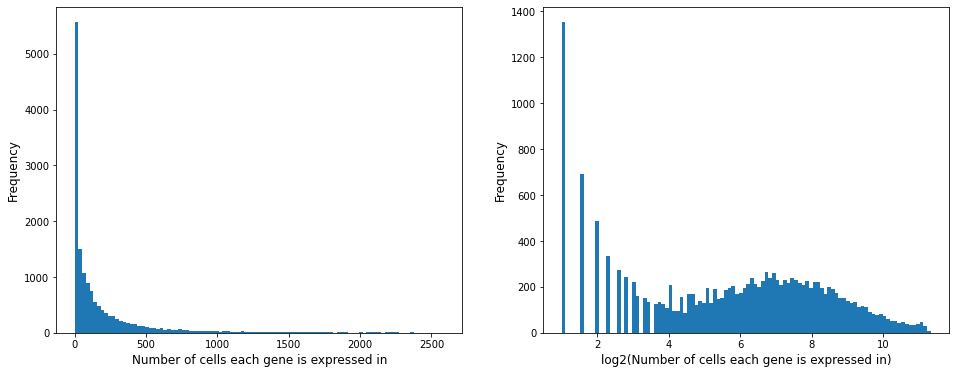

In [9]:
fig = plt.figure(figsize = (8*2, 6*1))

ax = fig.add_subplot(1, 2, 1)
ax.hist(adata.var['n_cells_by_counts'], 100);
ax.set_xlabel('Number of cells each gene is expressed in', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)

ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(adata.var['n_cells_by_counts'] + 1), 100);
ax.set_xlabel('log2(Number of cells each gene is expressed in)', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)

# Save figure
fig.savefig(output_directory + 'distr_gene_expression.png', bbox_inches = 'tight', dpi = 150)

plt.show()

As we can see, there is a large number of genes which are expressed in very few cells. You can choose to remove those genes from the analysis. A typical choice is to preserve only genes expressed in at least 10 cells. Or based on the distribution above (on the right), you can choose it to be 16: as log2(16) = 4.

You can run: `sc.pp.filter_genes(adata, min_cells=10)` to achieve that.

In this notebook, we do not set any threshold.

## Distribution of total counts in each cell

Next, we look at the distribution of the total counts (also known as the library size) in each cell. It is stored in 'total_counts' in adata.

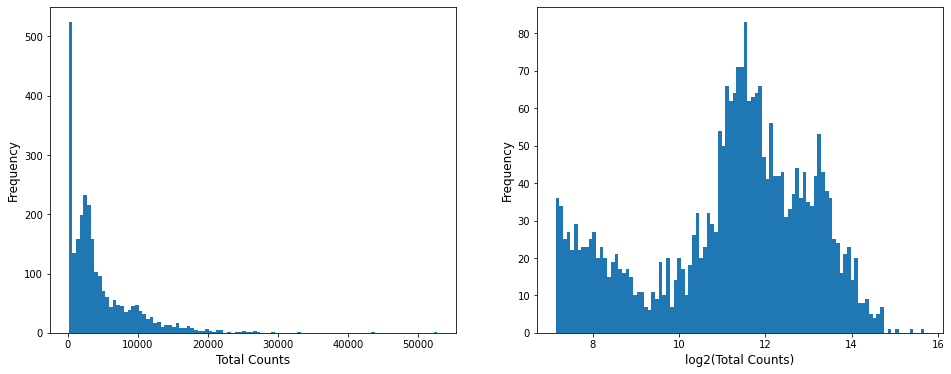

In [10]:
fig = plt.figure(figsize = (8*2, 6*1))

ax = fig.add_subplot(1, 2, 1)
ax.hist(adata.obs['total_counts'], 100);
ax.set_xlabel('Total Counts', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)

ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(adata.obs['total_counts'] + 1), 100);
ax.set_xlabel('log2(Total Counts)', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)

# Save figure
fig.savefig(output_directory + 'library_size_distribution.png', bbox_inches = 'tight', dpi = 150)

plt.show()

The library size distribution can inform you about the quality of cells in the data. Cells with very low library size (around 500) are likely to be empty droplets and not real cells. As such, it can be useful to remove such potential low quality cells. But one needs to be careful to ascertain that these are indeed lower quality cells. For that we recommend you include all the cells and perform some downstream analysis such as visualization and clustering. If these low library size (defined as the total counts in each cell) populations separate out as an independent cluster and do not seem to contribute to overall population then they can be classified as lower quality cells. So, whether to remove them from analysis is a choice that will need to be made gradually during data analysis process. 

If you decide to remove the lower quality cells, you can run the following code, which will remove cells with lower than 500 total counts. The choice of this threshold can also be inferred from the figure on the right ~9: because log2(512) = 9).

`sc.pp.filter_cells(adata, min_counts = 500)`

In this notebook, we don't filter out any cells.

## Mitochondrial content

The presence of high mitochondrial gene expression can indicate cells undergoing apoptosis. Therefore, it is of interest to inspect the rate of expression of mitochondrial genes. A typical step in scRNA-seq analysis involves removing cells with high mitochondrial RNA expression. But, whether to do so or not is a context dependent question. Sometimes you might be interested in studying cellular behavior under stress, which inevitably increases expression of mitochondrial content. 

Here, we provide code to look at mitochondrial content and suggest ways to remove cells with high content.

In [11]:
# Identify MT-genes
mito_genes = [x for x in adata.var.index if x[:3] == 'MT-']

In [12]:
print(mito_genes)

['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYTB', 'MT-ND4L']


In [13]:
location_mito_genes = [adata.var_names.get_loc(j) for j in mito_genes]

We define mitochondrial fraction for each cell as the total mitochondrial RNA counts divided by the total counts in that cell.

In [14]:
mito_frac = np.asarray(
    np.sum(adata.X[:, location_mito_genes], axis = 1)/np.sum(adata.X, axis = 1)
    ).squeeze() * 100

In [15]:
# store mitochondrial fraction onto adata
adata.obs['mito_frac'] = mito_frac

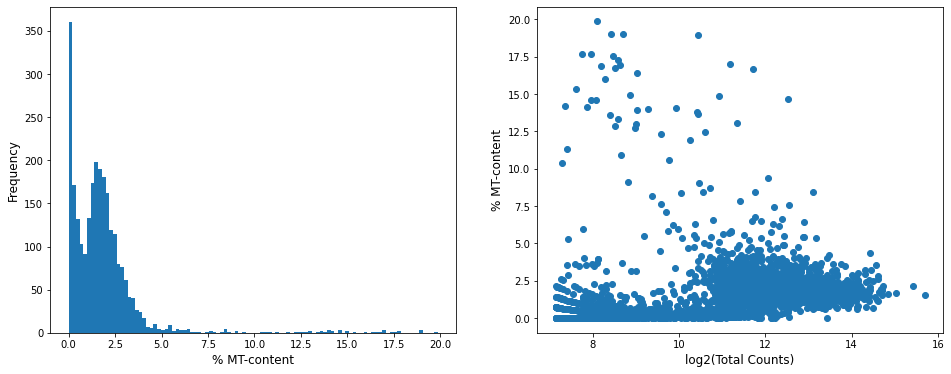

In [16]:
fig = plt.figure(figsize = (8*2, 6*1))

ax = fig.add_subplot(1, 2, 1)
ax.hist(mito_frac, 100);
ax.set_xlabel('% MT-content', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(np.log2(adata.obs['total_counts'] + 1), mito_frac);
ax.set_xlabel('log2(Total Counts)', fontsize = 12)
ax.set_ylabel('% MT-content', fontsize = 12)

# Save figure
fig.savefig(output_directory + 'mitochondrial_fraction.png', bbox_inches = 'tight', dpi = 150)

plt.show()

As you can see from the left plot, there are only very cells with substantially high MT-content. And from the figure on the right, you can see that those cells with high MT-content are also the ones with low total counts (or library size). As such, you could argue to remove these high MT-cells. 

# Highly Variable Gene selection

We select top 5000 highly variable genes for downstream analysis.

In [17]:
sc.pp.highly_variable_genes(adata, n_top_genes = 5000, flavor = 'seurat_v3')

We can identify the index of the highly variable genes and store them inside adata for later use:

In [18]:
adata.uns['id_hvg'] = np.where(adata.var['highly_variable'])[0]

In [19]:
adata.uns['id_hvg']

array([    1,     2,     4, ..., 15196, 15197, 15198])

We can visualize the selected genes on mean-counts by variance plot:

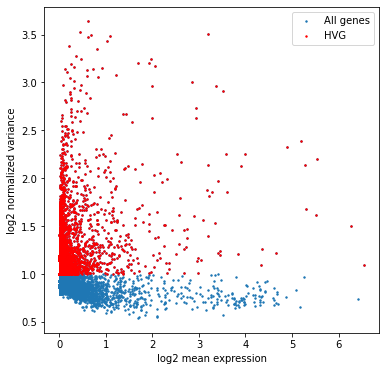

In [20]:
x = np.log2(adata.var['means'] + 1)
y = np.log2(adata.var['variances_norm'] + 1)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x, y, s = 2)
ax.scatter(x[adata.uns['id_hvg']], y[adata.uns['id_hvg']], s = 2, c = 'r')
ax.set_xlabel('log2 mean expression')
ax.set_ylabel('log2 normalized variance')
ax.legend(['All genes', 'HVG'])

plt.show()

# Data Normalization

We will perform median library size normalization followed by log transformation. This is the most common data normalization in scRNA-seq data analysis. 

Since most of our analysis will be on the log transformed data, we will reorganize some of the structure of adata. We will store log transformed data onto adata.X, while the raw counts and normalized counts will be stored as adata.layers.

In [21]:
# Median library size normalization
X_norm = sc.pp.normalize_total(adata, inplace = False)
adata.layers['norm_data'] = X_norm['X']

In [22]:
adata.layers['raw_data'] = adata.X

In [23]:
# Log transformation
if type(adata.layers['norm_data']) is sparse.csr.csr_matrix: 
    adata.X = np.log2(adata.layers['norm_data'].toarray() + 0.1) - np.log2(0.1)
else:
    adata.X = np.log2(adata.layers['norm_data'] + 0.1) - np.log2(0.1)

In [24]:
adata

AnnData object with n_obs × n_vars = 2610 × 15199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg'
    layers: 'norm_data', 'raw_data'

# Dimensionality reduction

## PCA

We first perform PCA on the highly variable genes.

In [25]:
sc.tl.pca(adata, n_comps = 50, use_highly_variable = True)

/Users/chunj/opt/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [26]:
adata

AnnData object with n_obs × n_vars = 2610 × 15199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'norm_data', 'raw_data'

As we can see, the principal components are stored in `adata.obsm['X_pca']`, the associated loadings are stored in `adata.varm['PCs']`, and the variance/variance-ratio explained by each components is saved in `adata.uns['pca']`.

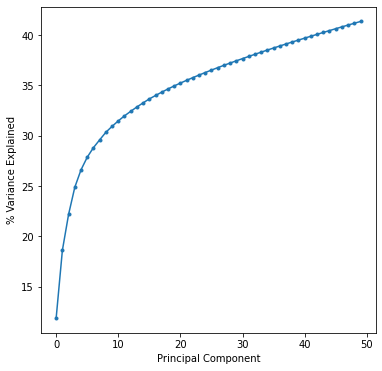

In [27]:
# Visualize variance explained:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(
    range(len(adata.uns['pca']['variance_ratio'])), 
    np.cumsum(adata.uns['pca']['variance_ratio']) * 100,
    '.-'
)
ax.set_xlabel('Principal Component')
ax.set_ylabel('% Variance Explained')

plt.show()

The above plot suggests that the top 50 principal components explain > 40% of the variance in the data.

## Nearest neighbors, UMAP

We compute k-nearest neighbor graph on the computed PCA (with the `n_neighbors` parameter set to 30).

In [28]:
sc.pp.neighbors(adata, n_neighbors = 30, use_rep = 'X_pca', random_state = 0)

In [29]:
adata

AnnData object with n_obs × n_vars = 2610 × 15199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'norm_data', 'raw_data'
    obsp: 'distances', 'connectivities'

The output of the nearest neighbor graph is stored in `adata.obsp['distances']`: nearest neighbor distance graph - and `adata.obsp['connectivities']`: nearest neighbor affinity graph. 

We now can run UMAP on the computed nearest graph, which will be stored in `adata.obsm['X_umap']`.

In [30]:
sc.tl.umap(adata, min_dist = 0.1)

In [31]:
adata

AnnData object with n_obs × n_vars = 2610 × 15199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_data', 'raw_data'
    obsp: 'distances', 'connectivities'

 ## Visualize some metadata onto UMAP

In [32]:
adata

AnnData object with n_obs × n_vars = 2610 × 15199
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_data', 'raw_data'
    obsp: 'distances', 'connectivities'

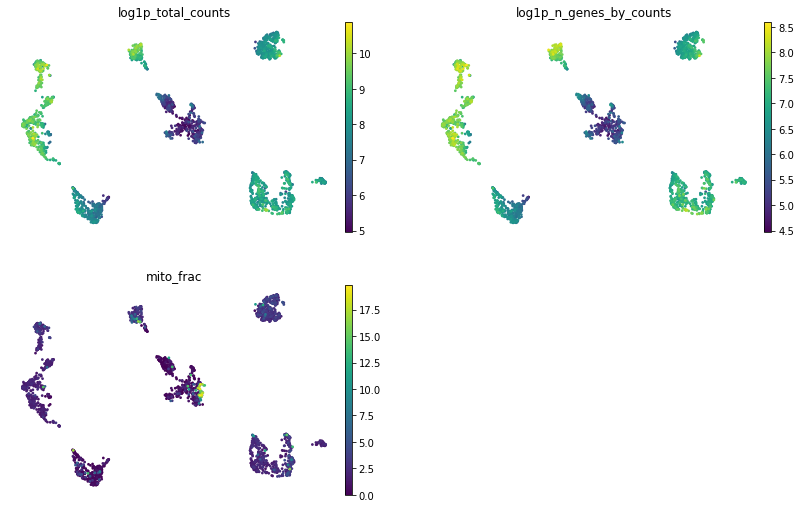

In [33]:
fig = sc.pl.umap(adata, color = ['log1p_total_counts', 'log1p_n_genes_by_counts', 'mito_frac'], size = 30,
           frameon = False, ncols = 2, return_fig = True)

# Save figure:
fig.savefig(os.path.join(output_directory, 'metadata_on_UMAP.png'), bbox_inches = 'tight', dpi = 150)

# Cluster

We now cluster the cells using PhenoGraph. We set the `k` parameter to be 30.

In [34]:
cluster, Q, graph = phenograph.cluster(adata.obsm['X_pca'], k = 30)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10938072204589844 seconds
Jaccard graph constructed in 0.2651088237762451 seconds
Wrote graph to binary file in 0.27440905570983887 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.881119
After 2 runs, maximum modularity is Q = 0.883416
Louvain completed 22 runs in 0.8860459327697754 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.7662138938903809 seconds


In [35]:
adata.obs['Clusters'] = pd.Categorical(cluster)

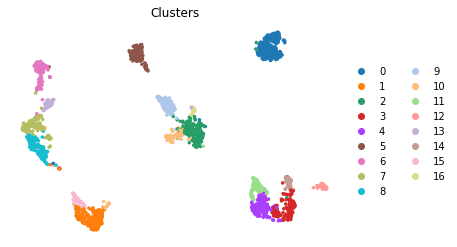

In [36]:
fig = sc.pl.umap(adata, color = ['Clusters'], size = 50, frameon = False, return_fig = True)

# Save figure:
fig.savefig(os.path.join(output_directory, 'clusters_on_UMAP.png'), bbox_inches = 'tight', dpi = 150)

# Write h5ad to Disk

In [37]:
adata.write_h5ad(
    os.path.join(output_directory, f"{sample_name}.processed.h5ad")
)